In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.spatial import ConvexHull
import cv2
from scipy.spatial.distance import cdist

## Utility Functions

In [2]:
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
            path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

def plot_shape(csv_path):
    csv_curve = read_csv(csv_path)
    plot(csv_curve)
    print("Number of curves:", len(csv_curve))

def plot_by_index(paths_XYs, index):
    if index < 0 or index >= len(paths_XYs):
        raise ValueError("Index out of range")

    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    XYs = paths_XYs[index]
    c = colours[index % len(colours)]
    for XY in XYs:
        ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)

    ax.set_aspect('equal')
    plt.show()

In [3]:
def get_corners(points, epsilon_factor=0.02):
    # Convert points to a format suitable for OpenCV
    points = np.array(points, dtype=np.float32).reshape((-1, 1, 2))
    
    # Calculate the perimeter of the shape
    perimeter = cv2.arcLength(points, True)
    
    # Approximate the contour with a polygon
    epsilon = epsilon_factor * perimeter
    approx = cv2.approxPolyDP(points, epsilon, True)
    
    # Extract corners from the approximation
    corners = [tuple(pt[0]) for pt in approx]
    
    return corners

def plot_shape_and_corners(points, corners):
    points = np.array(points)
    
    plt.figure(figsize=(8, 6))
    plt.plot(points[:, 0], points[:, 1], 'o-', label='Original Shape')
    
    corners = np.array(corners)
    plt.plot(corners[:, 0], corners[:, 1], 'ro', label='Corners')
    
    # for corner in corners:
    #     plt.text(corner[0], corner[1], f'({corner[0]}, {corner[1]})', fontsize=12, color='red')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Shape and Corners')
    plt.show()

def plot_convex_hull(points):
    # Convert points to a numpy array
    points = np.array(points)
    
    # Compute the convex hull
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    
    # Plot the original points
    plt.figure(figsize=(8, 8))
    plt.scatter(points[:, 0], points[:, 1], color='red', s=10, label='Original Points')
    
    # Plot the convex hull
    plt.plot(np.append(hull_points[:, 0], hull_points[0, 0]), np.append(hull_points[:, 1], hull_points[0, 1]), color='blue', linestyle='-', label='Convex Hull')
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.title('Original Points and Convex Hull')
    plt.show()

## Curve Identification

In [4]:
class CurveIdentification:
    def __init__(self, curve):
        self.curve = curve
    
    def is_straight_line(self, threshold=0.99):
        x = np.array([p[0] for p in self.curve]).reshape(-1, 1)
        y = np.array([p[1] for p in self.curve])
        
        model = LinearRegression().fit(x, y)
        y_pred = model.predict(x)
        
        r2 = r2_score(y, y_pred)
        return r2 >= threshold
    
    def is_convex_shape(self, threshold=100):
        self.curve = np.array(self.curve)
        
        # Compute the convex hull
        hull = ConvexHull(self.curve)
        
        # Compute the area of the original shape
        original_area = 0.5 * np.abs(np.dot(self.curve[:, 0], np.roll(self.curve[:, 1], 1)) - np.dot(self.curve[:, 1], np.roll(self.curve[:, 0], 1)))
        
        # Compute the area of the convex hull
        hull_points = self.curve[hull.vertices]
        hull_area = 0.5 * np.abs(np.dot(hull_points[:, 0], np.roll(hull_points[:, 1], 1)) - np.dot(hull_points[:, 1], np.roll(hull_points[:, 0], 1)))
        
        # Difference in area
        area_difference = hull_area - original_area
        
        return area_difference <= threshold
    
    def is_ellipse_or_circle(self, threshold=0.95):
        self.curve = np.array(self.curve)
    
        # Compute area using the Shoelace formula
        def polygon_area(pts):
            return 0.5 * np.abs(np.dot(pts[:, 0], np.roll(pts[:, 1], 1)) - np.dot(pts[:, 1], np.roll(pts[:, 0], 1)))
        
        # Compute perimeter
        def polygon_perimeter(pts):
            return np.sum(np.sqrt(np.sum(np.diff(np.vstack([pts, pts[0]]), axis=0)**2, axis=1)))
        
        area = polygon_area(self.curve)
        perimeter = polygon_perimeter(self.curve)
        
        # Compute circularity
        circularity = 4 * np.pi * area / (perimeter ** 2)
        
        return circularity >= threshold
    
    def is_circle(self, threshold=0.8):
        # get bounding box around shape
        self.curve = np.array(self.curve)
        min_x = np.min(self.curve[:, 0])
        max_x = np.max(self.curve[:, 0])
        min_y = np.min(self.curve[:, 1])
        max_y = np.max(self.curve[:, 1])

        # find aspect ratio of bounding box
        width = max_x - min_x
        height = max_y - min_y
        if height < width :
            width, height = height, width
        aspect_ratio = width / height

        return aspect_ratio >= threshold
    
    def identify(self):
        if self.is_straight_line() :
            return "Line"
        else:
            if self.is_convex_shape() :
                if self.is_ellipse_or_circle() :
                    if self.is_circle() :
                        return "Circle"
                    else :
                        return "Ellipse"
                else :
                    return "Regular Polygon"
            else :
                return "Star"

In [5]:
polylines = read_csv(r"C:\Users\suyash\OneDrive - iiit-b\Projects\Adobe_GenSolve\problems\problems\isolated.csv")

In [6]:
iden1 = CurveIdentification(polylines[0][0])
iden1.identify()

'Circle'

In [50]:
iden2 = CurveIdentification(polylines[1][0])
iden2.identify()

'Non-convex Star'

In [51]:
iden3 = CurveIdentification(polylines[2][0])
iden3.identify()

'Regular Polygon'

## Curve Fitting

In [123]:
class CurveFitting :
    def __init__ (self, curve):
        self.curve = curve

    def fit_line(self):
        return
    
    def fit_circle(self):
        def get_circle(circle_list):
            # calculate circle center using mean
            x, y = zip(*circle_list)
            x_center = np.mean(x)
            y_center = np.mean(y)

            # rearrange points such that origin becomes center
            u = x - x_center
            v = y - y_center

            # get radius by solving least mean squared error 
            distances = np.sqrt(u**2 + v**2)
            radius = np.mean(distances)

            # print(x_center, y_center, radius)
            return x_center, y_center, radius
    
        # plot original curve
        fig, ax = plt.subplots(tight_layout=True, figsize=(6, 6))
        colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
        c = colours[0]
        
        ax.plot(self.curve[:, 0], self.curve[:, 1], c=c, linewidth=2)

        # plot regularized curve
        x_center, y_center, radius = get_circle(self.curve)
        
        # Create an array of angles for the circle
        theta = np.linspace(0, 2 * np.pi, 100)
        
        # Parametric equations for a circle
        x_circle = x_center + radius * np.cos(theta)
        y_circle = y_center + radius * np.sin(theta)
        
        # Plot the circle and center of circle
        ax.plot(x_circle, y_circle, 'k-', linewidth=4)
        ax.plot(x_center, y_center, 'ro')  # 'ro' for red dot

        # Set equal scaling and labels
        ax.set_aspect('equal')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title('original_and_regularized_circle')
        ax.legend()
        
        # Show plot
        # plt.grid(True)
        plt.show()
    
    def fit_ellipse(self):
        # Convert the list of points to a numpy array
        self.curve = np.array(self.curve, dtype=np.float32)
        
        # Fit an ellipse to the points
        ellipse = cv2.fitEllipse(self.curve)
        
        # Extract ellipse parameters
        center, axes, angle = ellipse
        major_axis, minor_axis = axes
        
        # Create points along the ellipse
        theta = np.linspace(0, 2 * np.pi, 100)
        ellipse_points = np.array([
            center[0] + major_axis / 2 * np.cos(theta) * np.cos(np.radians(angle)) - minor_axis / 2 * np.sin(theta) * np.sin(np.radians(angle)),
            center[1] + major_axis / 2 * np.cos(theta) * np.sin(np.radians(angle)) + minor_axis / 2 * np.sin(theta) * np.cos(np.radians(angle))
        ]).T

        # Plot the original points
        plt.scatter(self.curve[:, 0], self.curve[:, 1], color='red', label='Original Points')
        
        # Plot the fitted ellipse
        plt.plot(ellipse_points[:, 0], ellipse_points[:, 1], 'k-', linewidth=4, label='Fitted Ellipse')
        
        plt.gca().set_aspect('equal', adjustable='box')
        plt.legend()
        plt.title('Original Points and Fitted Ellipse')
        plt.show() 
    
    def fit_rectangle(self):
        # Convert the list of points to a numpy array
        self.curve = np.array(self.curve, dtype=np.float32)
        
        # Fit a rotated rectangle to the points
        rect = cv2.minAreaRect(self.curve)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        
        # Create a plot
        plt.figure(figsize=(8, 8))
        
        # Plot the original points
        plt.scatter(self.curve[:, 0], self.curve[:, 1], color='red', label='Original Points')
        
        # Plot the fitted rectangle
        plt.plot(np.append(box[:, 0], box[0, 0]), np.append(box[:, 1], box[0, 1]), 'k-', linewidth=4, label='Fitted Rectangle')
        
        plt.gca().set_aspect('equal', adjustable='box')
        plt.legend()
        plt.title('Original Points and Fitted Rectangle')
        plt.show() 
    
    def fit_polygon(self):
        # Get corners of the approximated polygon
        corners = get_corners(self.curve)
        points = np.array(self.curve)
        corners = np.array(corners)

        # Calculate centroid of corners
        centroid = np.mean(corners, axis=0)

        # Find the point with the highest y-value to fix its position
        fixed_point = corners[np.argmax(corners[:, 1])]
        
        # Calculate radius from centroid to the fixed point
        radius = np.linalg.norm(fixed_point - centroid)
        
        # Calculate initial angle of the fixed point from the centroid
        initial_angle = np.arctan2(fixed_point[1] - centroid[1], fixed_point[0] - centroid[0])
        
        # Number of vertices
        num_vertices = len(corners)
        
        # Generate the regular polygon
        regular_polygon = []
        for i in range(num_vertices):
            angle = initial_angle + 2 * np.pi * i / num_vertices
            x = centroid[0] + radius * np.cos(angle)
            y = centroid[1] + radius * np.sin(angle)
            regular_polygon.append((x, y))
        
        regular_polygon = np.array(regular_polygon)
        
        # Plot original shape and fitted polygon
        plt.figure(figsize=(8, 6))
        plt.plot(points[:, 0], points[:, 1], 'o-', label='Original Shape')
        # plt.plot(corners[:, 0], corners[:, 1], 'ro-', label='Fitted Polygon')
        # plt.plot(regular_polygon[:, 0], regular_polygon[:, 1], 'g--', label='Regular Polygon')

        # Draw lines between consecutive points of the regular polygon
        for i in range(num_vertices):
            start_point = regular_polygon[i]
            end_point = regular_polygon[(i + 1) % num_vertices]
            plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'k-', linewidth=4)

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.title('Original Shape and Fitted Polygon')
        plt.show()
    
    def fit_star(self):
        # Get corners of the approximated polygon
        corners = get_corners(self.curve)
        points = np.array(self.curve)
        corners = np.array(corners)

        # Calculate centroid of corners
        centroid = np.mean(corners, axis=0)

        # Calculate distances from the centroid
        distances = np.linalg.norm(corners - centroid, axis=1)

        # Separate outer and inner points based on distances
        sorted_indices = np.argsort(distances)
        half = len(corners) // 2

        outer_points = corners[sorted_indices[half:]]
        inner_points = corners[sorted_indices[:half]]

        # Find the fixed outer point with the highest y-value
        fixed_outer_point = outer_points[np.argmax(outer_points[:, 1])]
        
        # Calculate radius for outer and inner points
        outer_radius = np.linalg.norm(fixed_outer_point - centroid)
        inner_radius = np.mean([np.linalg.norm(pt - centroid) for pt in inner_points])

        # Calculate initial angle of the fixed outer point from the centroid
        initial_angle = np.arctan2(fixed_outer_point[1] - centroid[1], fixed_outer_point[0] - centroid[0])

        # Number of vertices
        num_vertices = len(corners) // 2

        # Generate the star points
        star_points = []
        for i in range(num_vertices):
            # Calculate the angle for the outer point
            angle_outer = initial_angle + 2 * np.pi * i / num_vertices
            x_outer = centroid[0] + outer_radius * np.cos(angle_outer)
            y_outer = centroid[1] + outer_radius * np.sin(angle_outer)
            star_points.append((x_outer, y_outer))

            # Calculate the angle for the inner point (between two outer points)
            angle_inner = initial_angle + 2 * np.pi * (i + 0.5) / num_vertices
            x_inner = centroid[0] + inner_radius * np.cos(angle_inner)
            y_inner = centroid[1] + inner_radius * np.sin(angle_inner)
            star_points.append((x_inner, y_inner))

        star_points = np.array(star_points)

        # Plot original shape and fitted star
        plt.figure(figsize=(8, 6))
        plt.plot(points[:, 0], points[:, 1], 'o-', label='Original Shape')
        # plt.plot(corners[:, 0], corners[:, 1], 'ro-', label='Fitted Polygon')
        # plt.plot(star_points[:, 0], star_points[:, 1], 'k-', linewidth=2, label='Fitted Star')

        # Draw lines between consecutive points of the star
        for i in range(len(star_points)):
            start_point = star_points[i]
            end_point = star_points[(i + 1) % len(star_points)]
            plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'k-', linewidth=4)

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.title('Original Shape and Fitted Star')
        plt.show()
    
    def fit_convex_hull(self):
        # Convert points to a numpy array
        self.curve = np.array(self.curve)
        
        # Compute the convex hull
        hull = ConvexHull(self.curve)
        hull_points = self.curve[hull.vertices]
        
        # Plot the original points
        plt.figure(figsize=(8, 8))
        plt.scatter(self.curve[:, 0], self.curve[:, 1], color='red', s=10, label='Original Points')
        
        # Plot the convex hull
        plt.plot(np.append(hull_points[:, 0], hull_points[0, 0]), np.append(hull_points[:, 1], hull_points[0, 1]), color='blue', linestyle='-', label='Convex Hull')
        
        plt.gca().set_aspect('equal', adjustable='box')
        plt.legend()
        plt.title('Original Points and Convex Hull')
        plt.show()

    def fit_curve(self, curve_type):
        if curve_type == "Circle":
            self.fit_circle()
        elif curve_type == "Ellipse":
            self.fit_ellipse()
        elif curve_type == "Line":
            self.fit_line()
        elif curve_type == "Rectangle":
            # self.fit_rectangle()
            self.fit_polygon()
        elif curve_type == "Star":
            self.fit_star()
        elif curve_type == "Regular Polygon":
            self.fit_polygon()

In [133]:
class CurveFitting2 :
    def __init__ (self, curve):
        self.curve = curve

    def fit_line(self):
        return
    
    def fit_circle(self, ax, color):
        def get_circle(circle_list):
            # calculate circle center using mean
            x, y = zip(*circle_list)
            x_center = np.mean(x)
            y_center = np.mean(y)

            # rearrange points such that origin becomes center
            u = x - x_center
            v = y - y_center

            # get radius by solving least mean squared error 
            distances = np.sqrt(u**2 + v**2)
            radius = np.mean(distances)

            # print(x_center, y_center, radius)
            return x_center, y_center, radius
    
        # plot original curve
        # ax.plot(self.curve[:, 0], self.curve[:, 1], c='b', linewidth=2)

        # plot regularized curve
        x_center, y_center, radius = get_circle(self.curve)
        
        # Create an array of angles for the circle
        theta = np.linspace(0, 2 * np.pi, 100)
        
        # Parametric equations for a circle
        x_circle = x_center + radius * np.cos(theta)
        y_circle = y_center + radius * np.sin(theta)
        
        # Plot the circle and center of circle
        ax.plot(x_circle, y_circle, c=color, linewidth=3)
        # ax.plot(x_center, y_center, 'ro')  # 'ro' for red dot

        # Set equal scaling and labels
        ax.set_aspect('equal')
        ax.legend()
    
    def fit_ellipse(self, ax, color):
        # Convert the list of points to a numpy array
        self.curve = np.array(self.curve, dtype=np.float32)
        
        # Fit an ellipse to the points
        ellipse = cv2.fitEllipse(self.curve)
        
        # Extract ellipse parameters
        center, axes, angle = ellipse
        major_axis, minor_axis = axes
        
        # Create points along the ellipse
        theta = np.linspace(0, 2 * np.pi, 100)
        ellipse_points = np.array([
            center[0] + major_axis / 2 * np.cos(theta) * np.cos(np.radians(angle)) - minor_axis / 2 * np.sin(theta) * np.sin(np.radians(angle)),
            center[1] + major_axis / 2 * np.cos(theta) * np.sin(np.radians(angle)) + minor_axis / 2 * np.sin(theta) * np.cos(np.radians(angle))
        ]).T

        # Plot the original points
        # ax.scatter(self.curve[:, 0], self.curve[:, 1], color='red', label='Original Points')
        
        # Plot the fitted ellipse
        ax.plot(ellipse_points[:, 0], ellipse_points[:, 1], c=color, linewidth=3, label='Fitted Ellipse')
        ax.gca().set_aspect('equal', adjustable='box')
        ax.legend()
    
    def fit_rectangle(self, ax, color):
        # Convert the list of points to a numpy array
        self.curve = np.array(self.curve, dtype=np.float32)
        
        # Fit a rotated rectangle to the points
        rect = cv2.minAreaRect(self.curve)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        
        # Plot the original points
        # ax.scatter(self.curve[:, 0], self.curve[:, 1], color='red', label='Original Points')
        
        # Plot the fitted rectangle
        ax.plot(np.append(box[:, 0], box[0, 0]), np.append(box[:, 1], box[0, 1]), c=color, linewidth=3, label='Fitted Rectangle')
        ax.gca().set_aspect('equal', adjustable='box')
        ax.legend()
    
    def fit_polygon(self, ax, color):
        # Get corners of the approximated polygon
        corners = get_corners(self.curve)
        points = np.array(self.curve)
        corners = np.array(corners)

        # Calculate centroid of corners
        centroid = np.mean(corners, axis=0)

        # Find the point with the highest y-value to fix its position
        fixed_point = corners[np.argmax(corners[:, 1])]
        
        # Calculate radius from centroid to the fixed point
        radius = np.linalg.norm(fixed_point - centroid)
        
        # Calculate initial angle of the fixed point from the centroid
        initial_angle = np.arctan2(fixed_point[1] - centroid[1], fixed_point[0] - centroid[0])
        
        # Number of vertices
        num_vertices = len(corners)
        
        # Generate the regular polygon
        regular_polygon = []
        for i in range(num_vertices):
            angle = initial_angle + 2 * np.pi * i / num_vertices
            x = centroid[0] + radius * np.cos(angle)
            y = centroid[1] + radius * np.sin(angle)
            regular_polygon.append((x, y))
        
        regular_polygon = np.array(regular_polygon)
        
        # Plot original shape and fitted polygon
        # ax.plot(points[:, 0], points[:, 1], 'o-', label='Original Shape')

        # Draw lines between consecutive points of the regular polygon
        for i in range(num_vertices):
            start_point = regular_polygon[i]
            end_point = regular_polygon[(i + 1) % num_vertices]
            ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], c=color, linewidth=3)

        ax.legend()
    
    def fit_star(self, ax, color):
        # Get corners of the approximated polygon
        corners = get_corners(self.curve)
        points = np.array(self.curve)
        corners = np.array(corners)

        # Calculate centroid of corners
        centroid = np.mean(corners, axis=0)

        # Calculate distances from the centroid
        distances = np.linalg.norm(corners - centroid, axis=1)

        # Separate outer and inner points based on distances
        sorted_indices = np.argsort(distances)
        half = len(corners) // 2

        outer_points = corners[sorted_indices[half:]]
        inner_points = corners[sorted_indices[:half]]

        # Find the fixed outer point with the highest y-value
        fixed_outer_point = outer_points[np.argmax(outer_points[:, 1])]
        
        # Calculate radius for outer and inner points
        outer_radius = np.linalg.norm(fixed_outer_point - centroid)
        inner_radius = np.mean([np.linalg.norm(pt - centroid) for pt in inner_points])

        # Calculate initial angle of the fixed outer point from the centroid
        initial_angle = np.arctan2(fixed_outer_point[1] - centroid[1], fixed_outer_point[0] - centroid[0])

        # Number of vertices
        num_vertices = len(corners) // 2

        # Generate the star points
        star_points = []
        for i in range(num_vertices):
            # Calculate the angle for the outer point
            angle_outer = initial_angle + 2 * np.pi * i / num_vertices
            x_outer = centroid[0] + outer_radius * np.cos(angle_outer)
            y_outer = centroid[1] + outer_radius * np.sin(angle_outer)
            star_points.append((x_outer, y_outer))

            # Calculate the angle for the inner point (between two outer points)
            angle_inner = initial_angle + 2 * np.pi * (i + 0.5) / num_vertices
            x_inner = centroid[0] + inner_radius * np.cos(angle_inner)
            y_inner = centroid[1] + inner_radius * np.sin(angle_inner)
            star_points.append((x_inner, y_inner))

        star_points = np.array(star_points)

        # Plot original shape and fitted star
        # ax.plot(points[:, 0], points[:, 1], 'o-', label='Original Shape')

        # Draw lines between consecutive points of the star
        for i in range(len(star_points)):
            start_point = star_points[i]
            end_point = star_points[(i + 1) % len(star_points)]
            ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], c=color, linewidth=3)

        ax.legend()
    
    def fit_convex_hull(self, ax, color):
        # Convert points to a numpy array
        self.curve = np.array(self.curve)
        
        # Compute the convex hull
        hull = ConvexHull(self.curve)
        hull_points = self.curve[hull.vertices]
        
        # Plot the original points
        # ax.scatter(self.curve[:, 0], self.curve[:, 1], color='red', s=10, label='Original Points')
        
        # Plot the convex hull
        ax.plot(np.append(hull_points[:, 0], hull_points[0, 0]), np.append(hull_points[:, 1], hull_points[0, 1]), c=color, linestyle='-', label='Convex Hull')
        ax.gca().set_aspect('equal', adjustable='box')
        ax.legend()

    def fit_curve(self, curve_type, ax, color):
        if curve_type == "Circle":
            self.fit_circle(ax, color)
        elif curve_type == "Ellipse":
            self.fit_ellipse(ax, color)
        elif curve_type == "Line":
            self.fit_line(ax, color)
        elif curve_type == "Rectangle":
            # self.fit_rectangle(ax, color)
            self.fit_polygon(ax, color)
        elif curve_type == "Star":
            self.fit_star(ax, color)
        elif curve_type == "Regular Polygon":
            self.fit_polygon(ax, color)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


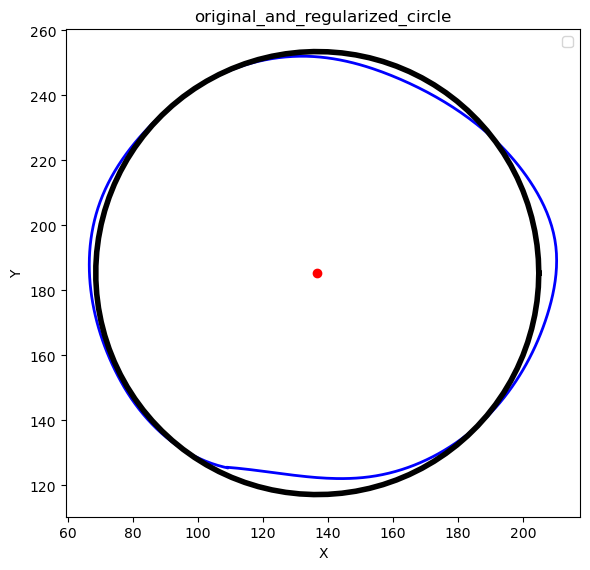

In [119]:
fitting1 = CurveFitting(polylines[0][0])
fitting1.fit_circle()

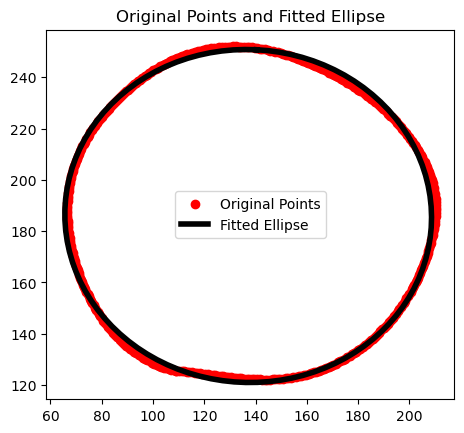

In [112]:
fitting1.fit_ellipse()

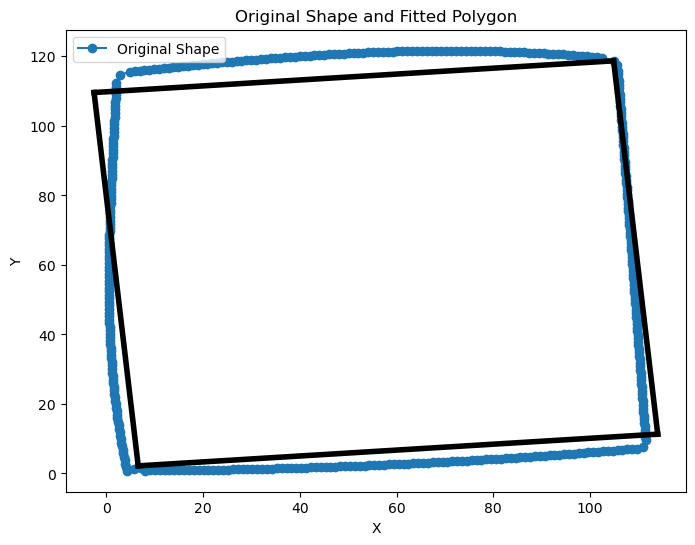

In [113]:
fitting2 = CurveFitting(polylines[2][0])
fitting2.fit_polygon()

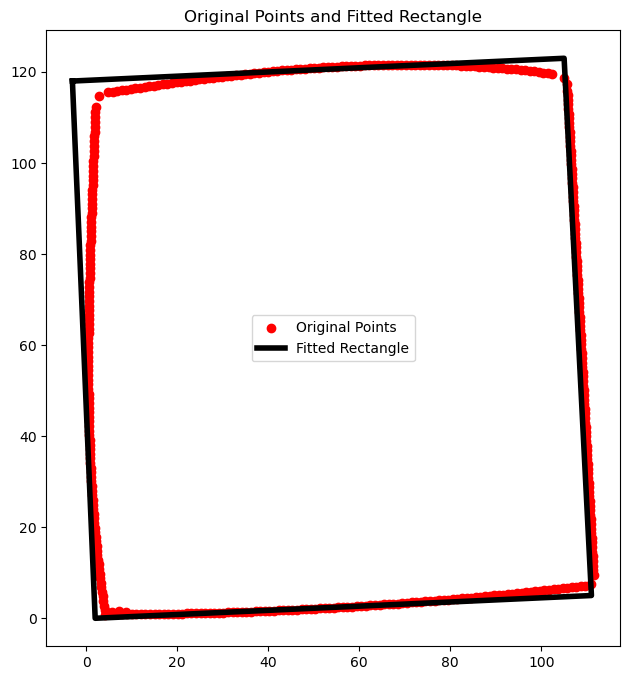

In [114]:
fitting4 = CurveFitting(polylines[2][0])
fitting4.fit_rectangle()

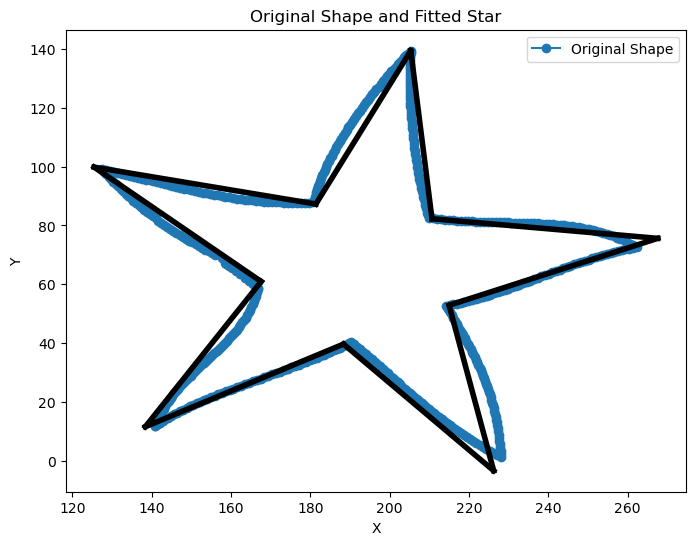

In [115]:
fitting3 = CurveFitting(polylines[1][0])
fitting3.fit_star()

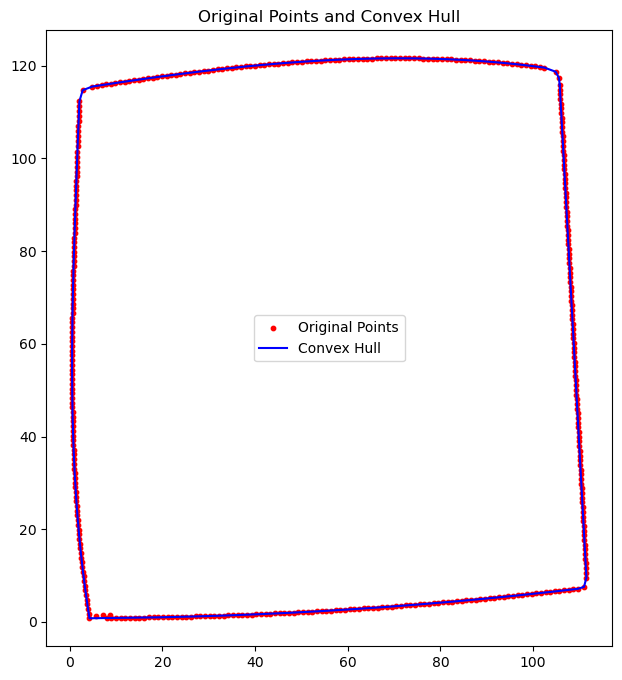

In [63]:
fitting2.fit_convex_hull()

## Regularization

In [136]:
class Regularize:
    def __init__(self, curveList):
        self.curveList = curveList

    def regularize(self, curve, ax, color):
        curve_identification = CurveIdentification(curve)
        curve_type = curve_identification.identify()

        curve_fitting = CurveFitting2(curve)
        curve_fitting.fit_curve(curve_type, ax, color)

    def regularize_all(self):
        fig, ax = plt.subplots(figsize=(8, 6))
        colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
        curve_number = 0
        ax.set_title("Regularized Shapes")
        for curve in self.curveList:
            color = colours[curve_number % len(colours)]
            self.regularize(curve[0], ax, color)
            curve_number += 1
        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


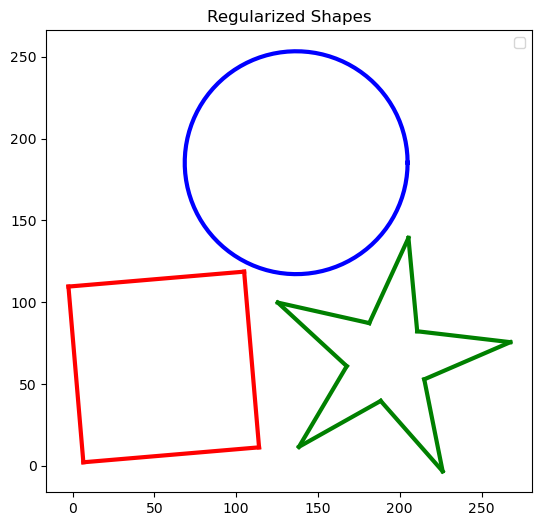

In [137]:
reg = Regularize(polylines)
reg.regularize_all()

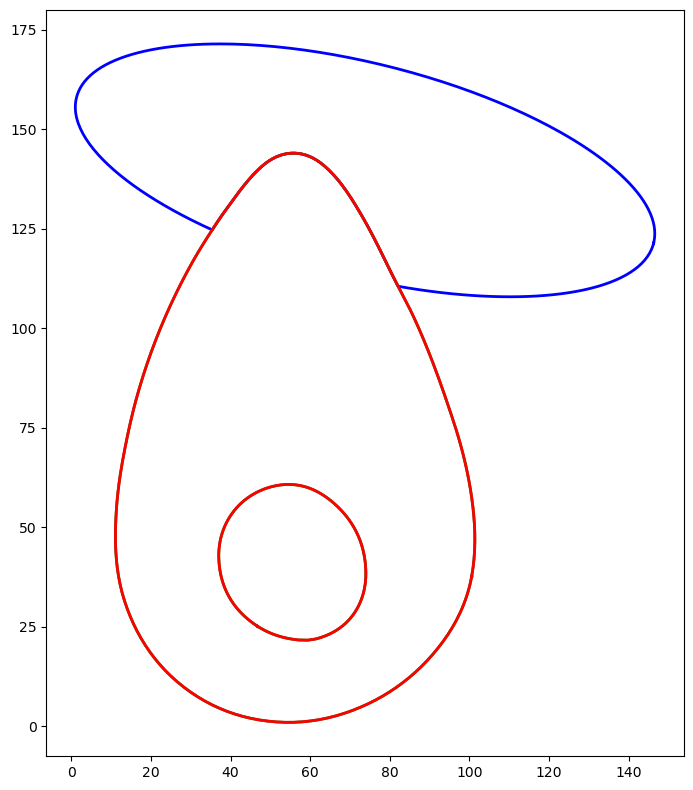

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of curves: 3


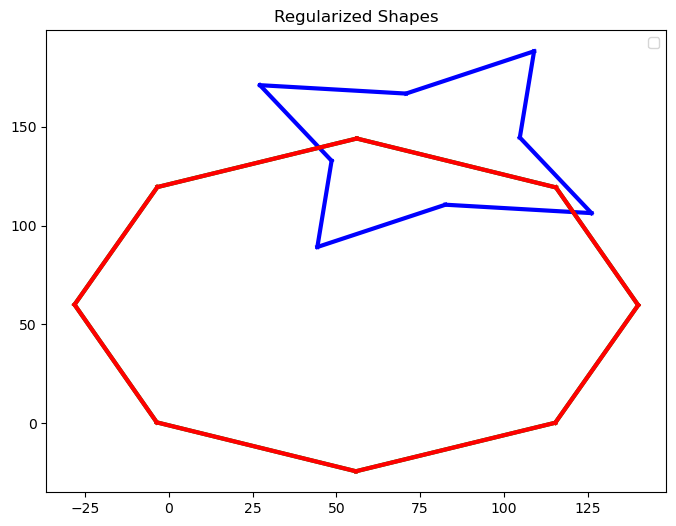

In [157]:
occlusion_path = r"C:\Users\suyash\OneDrive - iiit-b\Projects\Adobe_GenSolve\problems\problems\occlusion1.csv"
occlusion = read_csv(occlusion_path)
plot_shape(occlusion_path)

reg2 = Regularize(occlusion)
reg2.regularize_all()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


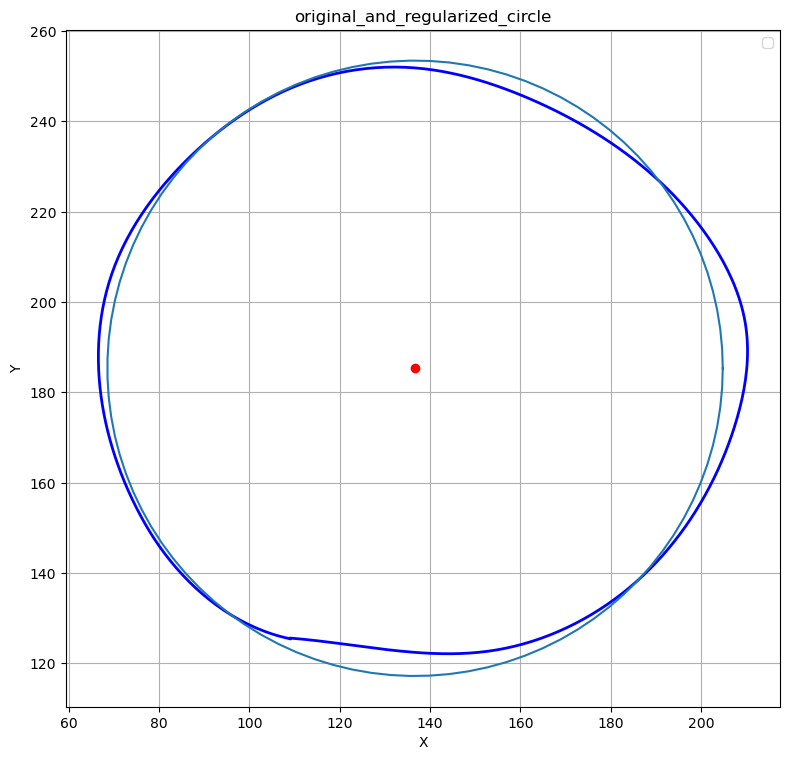

In [67]:
regular = Regularize(polylines[0][0])
regular.regularize()

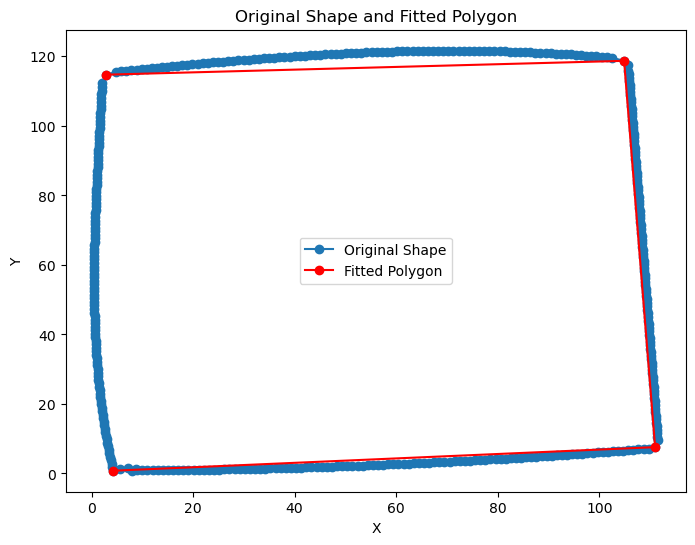

In [84]:
regular2 = Regularize(polylines[2][0])
regular2.regularize()

## Symmetry

In [75]:
class Symmetry:
    def __init__(self, curve):
        self.curve = curve
    
    def line_symmetry(self, curve_type):
        if curve_type == "Regular Polygon":
            return
        elif curve_type == "Ellipse":
            return
    
    def radial_symmetry(self, curve_type):
        if curve_type == "Circle" :
            x, y = zip(*self.curve)
            x_center = np.mean(x)
            y_center = np.mean(y)
            return x_center, y_center
        
        elif curve_type == "Regular Polygon" :
            get_corners()
    
    def get_symmetry(self, curve_type):
        self.line_symmetry(curve_type)
        self.radial_symmetry(curve_type)
        

Corners: [(140.844, 11.847), (190.326, 40.5), (228.09, 1.226), (214.2, 52.654), (262.277, 72.643), (209.859, 82.605), (205.319, 139.337), (180.777, 87.813), (127.422, 99.151), (166.888, 58.292)]


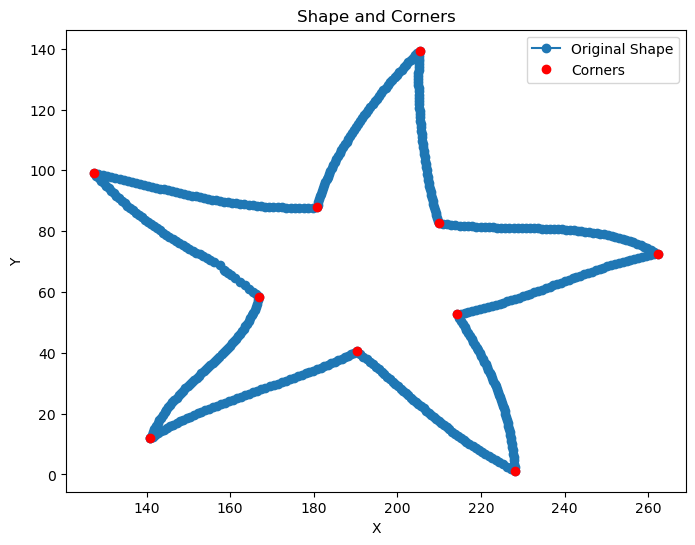

In [76]:
corners = get_corners(polylines[1][0])
print("Corners:", corners)
plot_shape_and_corners(polylines[1][0], corners)

Corners: [(4.26, 0.779), (110.979, 7.56), (104.871, 118.715), (2.792, 114.73)]


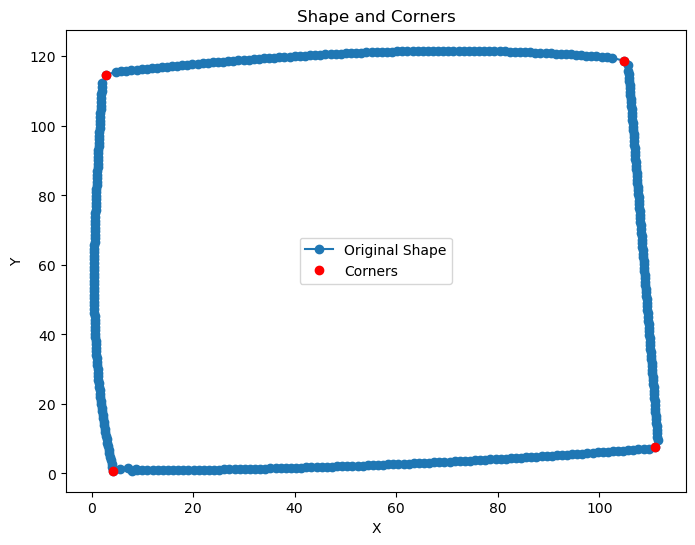

In [72]:
corners2 = get_corners(polylines[2][0])
print("Corners:", corners2)
plot_shape_and_corners(polylines[2][0], corners2)

In [153]:
def fit_star(curve, ax, color):
    # Get corners of the approximated polygon
    corners = get_corners(curve)
    points = np.array(curve)
    corners = np.array(corners)

    # Calculate centroid of corners
    centroid = np.mean(corners, axis=0)

    # Calculate distances from the centroid
    distances = np.linalg.norm(corners - centroid, axis=1)

    # Separate outer and inner points based on distances
    sorted_indices = np.argsort(distances)
    half = len(corners) // 2

    outer_points = corners[sorted_indices[half:]]
    inner_points = corners[sorted_indices[:half]]

    # Find the fixed outer point with the highest y-value
    fixed_outer_point = outer_points[np.argmax(outer_points[:, 1])]
    
    # Calculate radius for outer and inner points
    outer_radius = np.linalg.norm(fixed_outer_point - centroid)
    inner_radius = np.mean([np.linalg.norm(pt - centroid) for pt in inner_points])

    # Calculate initial angle of the fixed outer point from the centroid
    initial_angle = np.arctan2(fixed_outer_point[1] - centroid[1], fixed_outer_point[0] - centroid[0])

    # Number of vertices
    num_vertices = len(corners) // 2

    # Generate the star points
    star_points = []
    for i in range(num_vertices):
        # Calculate the angle for the outer point
        angle_outer = initial_angle + 2 * np.pi * i / num_vertices
        x_outer = centroid[0] + outer_radius * np.cos(angle_outer)
        y_outer = centroid[1] + outer_radius * np.sin(angle_outer)
        star_points.append((x_outer, y_outer))

        # Calculate the angle for the inner point (between two outer points)
        angle_inner = initial_angle + 2 * np.pi * (i + 0.5) / num_vertices
        x_inner = centroid[0] + inner_radius * np.cos(angle_inner)
        y_inner = centroid[1] + inner_radius * np.sin(angle_inner)
        star_points.append((x_inner, y_inner))

    star_points = np.array(star_points)

    # Plot original shape and fitted star
    # ax.plot(points[:, 0], points[:, 1], 'o-', label='Original Shape')

    # Draw lines between consecutive points of the star
    for i in range(len(star_points)):
        start_point = star_points[i]
        end_point = star_points[(i + 1) % len(star_points)]
        ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], c=color, linewidth=3)

    # Draw dotted radial symmetry lines from centroid to inner radius points
    # for i in range(1, len(star_points), 2):  # inner points are at odd indices
    #     inner_point = star_points[i]
    #     ax.plot([centroid[0], inner_point[0]], [centroid[1], inner_point[1]], c="g", linestyle='dotted')

    # Draw dotted radial symmetry lines from centroid to slightly beyond inner radius points
    for i in range(1, len(star_points), 2):  # inner points are at odd indices
        inner_point = star_points[i]
        direction_vector = inner_point - centroid
        extended_inner_point = inner_point + direction_vector
        ax.plot([centroid[0], extended_inner_point[0]], [centroid[1], extended_inner_point[1]], c="g", linestyle='dotted')

    ax.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


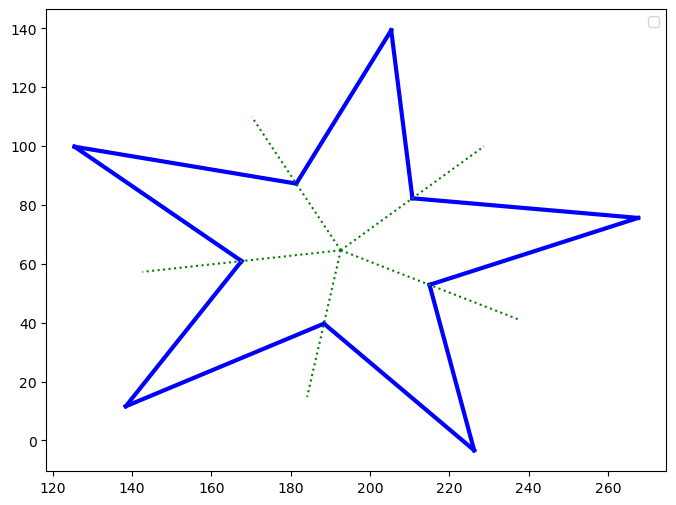

In [154]:
fig, ax = plt.subplots(figsize=(8, 6))
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
color = colours[0]

fit_star(polylines[1][0], ax, color)

### Lines of Symmetry

In [7]:
rec_list = polylines[2][0]

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to convert list of (x, y) coordinates to binary image
def coords_to_binary_image(coords, image_size=(500, 500)):
    # Create an empty binary image
    binary_image = np.zeros(image_size, dtype=np.uint8)
    
    # Scale coordinates to fit within the image dimensions
    coords = np.array(coords)
    coords -= coords.min(axis=0)
    coords = coords / coords.max(axis=0) * (np.array(image_size) - 1)
    coords = coords.astype(int)
    
    # Draw the shape on the binary image
    for coord in coords:
        binary_image[coord[1], coord[0]] = 255
    
    return binary_image

# Function to calculate symmetry score for a given axis
def symmetry_score(binary_image, axis_angle):
    # Get image dimensions
    h, w = binary_image.shape
    
    # Calculate the reflection matrix
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, axis_angle, 1)
    reflected_image = cv2.warpAffine(binary_image, M, (w, h))
    
    # Calculate the similarity between original and reflected image
    similarity = np.sum(binary_image == reflected_image)
    score = similarity / (w * h)
    
    return score

# Function to find the best symmetry axis
def find_best_symmetry_axis(binary_image):
    best_score = 0
    best_angle = 0
    
    # Test symmetry across various angles
    for angle in range(0, 180):
        score = symmetry_score(binary_image, angle)
        if score > best_score:
            best_score = score
            best_angle = angle
    
    return best_angle, best_score

# Function to plot the results
def plot_results(binary_image, best_angle):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Original Shape')
    plt.imshow(binary_image, cmap='gray')
    
    plt.subplot(1, 2, 2)
    plt.title(f'Symmetry Axis at {best_angle} degrees')
    plt.imshow(binary_image, cmap='gray')
    plt.axline((0, 0), slope=np.tan(np.radians(best_angle)), color='r')
    
    plt.show()

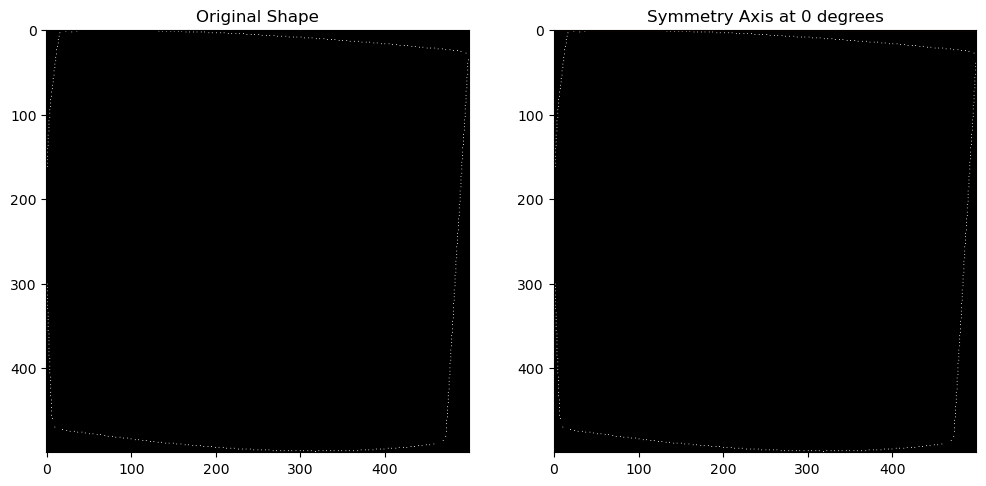

In [12]:
# Convert coordinates to binary image
binary_image = coords_to_binary_image(rec_list)

# Find the best symmetry axis
best_angle, best_score = find_best_symmetry_axis(binary_image)

# Plot results
plot_results(binary_image, best_angle)

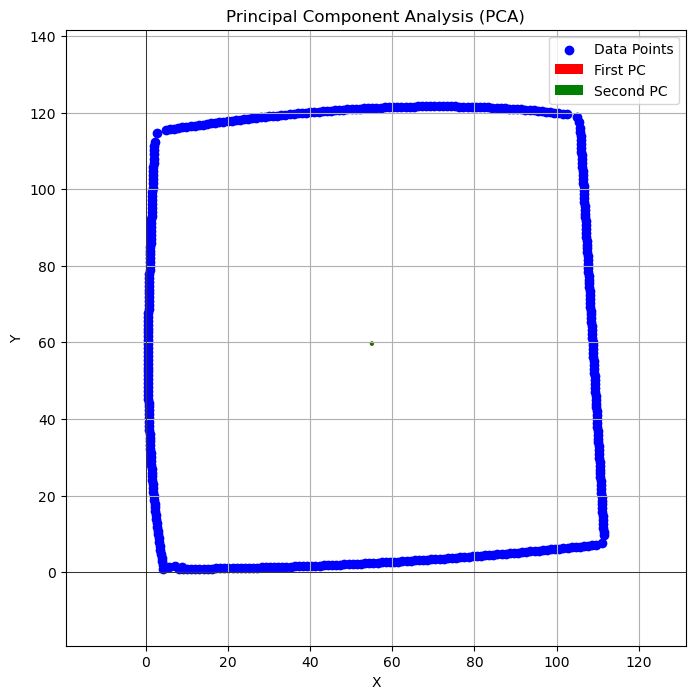

Explained Variance by First PC: 0.53
Explained Variance by Second PC: 0.47


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Example input: List of (x, y) coordinates
coords = np.array(rec_list)

# Perform PCA
pca = PCA(n_components=2)  # We are using 2 components as it's a 2D space
pca.fit(coords)

# Get the principal components
pc1 = pca.components_[0]  # First principal component
pc2 = pca.components_[1]  # Second principal component
explained_variance = pca.explained_variance_ratio_

# Mean of the points (center of the data)
mean_point = np.mean(coords, axis=0)

# Plotting the points and principal components
plt.figure(figsize=(8, 8))
plt.scatter(coords[:, 0], coords[:, 1], label='Data Points', color='blue')

# Plot first principal component
plt.quiver(mean_point[0], mean_point[1], 
           pc1[0], pc1[1], 
           angles='xy', scale_units='xy', scale=1, color='red', label='First PC')

# Plot second principal component
plt.quiver(mean_point[0], mean_point[1], 
           pc2[0], pc2[1], 
           angles='xy', scale_units='xy', scale=1, color='green', label='Second PC')

plt.xlim(coords[:, 0].min()-20, coords[:, 0].max()+20)
plt.ylim(coords[:, 1].min()-20, coords[:, 1].max()+20)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Principal Component Analysis (PCA)')
plt.grid(True)
plt.show()

print(f"Explained Variance by First PC: {explained_variance[0]:.2f}")
print(f"Explained Variance by Second PC: {explained_variance[1]:.2f}")

In [31]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def draw_principal_components(image, n_components=1):
    # Find non-zero pixels in the image
    coords = np.column_stack(np.where(image > 0))

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca.fit(coords)

    # Get the principal components and the mean
    components = pca.components_
    mean_point = np.mean(coords, axis=0)

    # Convert to color image to draw colored lines
    if len(image.shape) == 2:
        color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        color_image = image.copy()

    # Draw the principal components
    for i, component in enumerate(components):
        # Start point is the center (mean point)
        start_point = mean_point.astype(int)
        
        # Extend the line in both directions
        end_point1 = (mean_point + component * 100).astype(int)  # Extend in the positive direction
        end_point2 = (mean_point - component * 100).astype(int)  # Extend in the negative direction
        
        # Define colors for each principal component
        color = (0, 255, 0) if i == 0 else (0, 0, 255) if i == 1 else (255, 0, 0)  # Green for 1st PC, Red for 2nd, Blue for 3rd
        
        # Draw the line from one end to the other
        cv2.line(color_image, tuple(end_point1[::-1]), tuple(end_point2[::-1]), color, 2)
    
    return color_image, pca

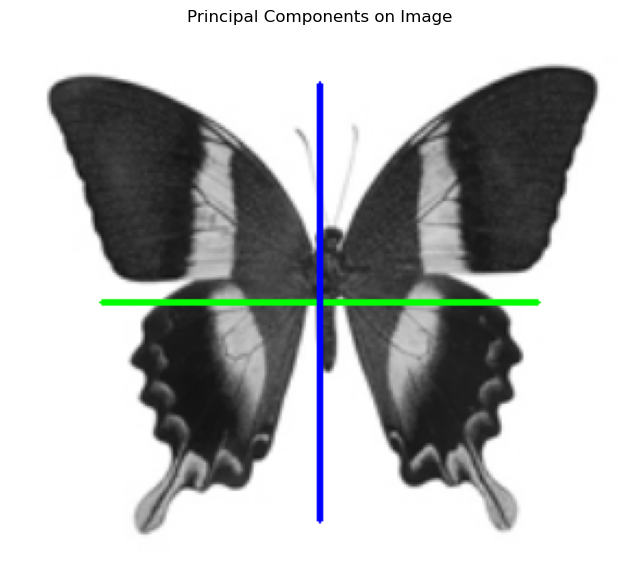

Explained Variance Ratios: [0.56122216 0.43877784]


In [22]:
# Function to load and convert an image to grayscale
def load_and_convert_to_grayscale(image_path):
    # Load the image from the given path
    image = cv2.imread(image_path)
    
    # Check if the image was successfully loaded
    if image is None:
        raise ValueError(f"Image not found at {image_path}")
    
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    return gray_image

# Example usage
image_path = r"C:\Users\suyash\OneDrive - iiit-b\Projects\Adobe_GenSolve\butterfly.png"
image = load_and_convert_to_grayscale(image_path)

# cv2.rectangle(image, (150, 150), (350, 350), 255, -1)  # Drawing a white rectangle for testing

# Draw principal components
result_image, pca = draw_principal_components(image, n_components=2)

# Plot the result
plt.figure(figsize=(8, 8))
plt.imshow(result_image, cmap='gray')
plt.title('Principal Components on Image')
plt.axis('off')
plt.show()

print(f"Explained Variance Ratios: {pca.explained_variance_ratio_}")

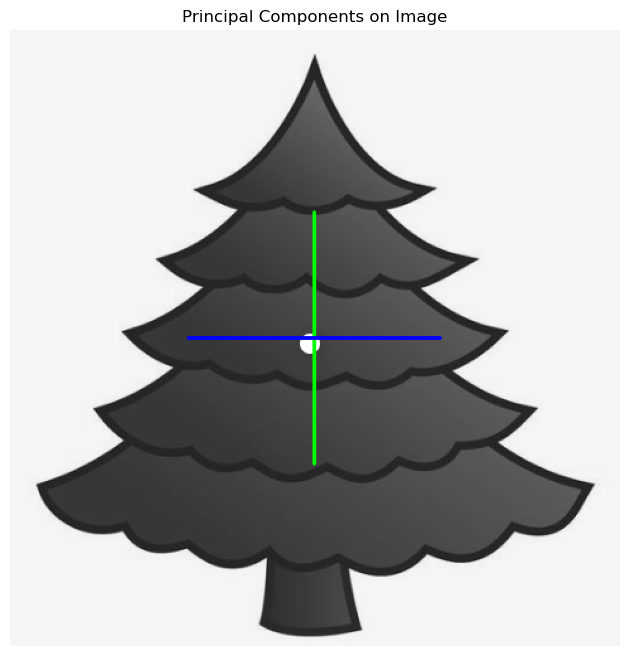

Explained Variance Ratios: [0.56122216 0.43877784]


In [27]:
# Example usage
image_path2 = r"C:\Users\suyash\OneDrive - iiit-b\Projects\Adobe_GenSolve\tree.png"
image2 = load_and_convert_to_grayscale(image_path2)

# cv2.rectangle(image, (150, 150), (350, 350), 255, -1)  # Drawing a white rectangle for testing

# Draw principal components
result_image2, pca2 = draw_principal_components(image2, n_components=2)

# Plot the result
plt.figure(figsize=(8, 8))
plt.imshow(result_image2, cmap='gray')
plt.title('Principal Components on Image')
plt.axis('off')
plt.show()

print(f"Explained Variance Ratios: {pca.explained_variance_ratio_}")

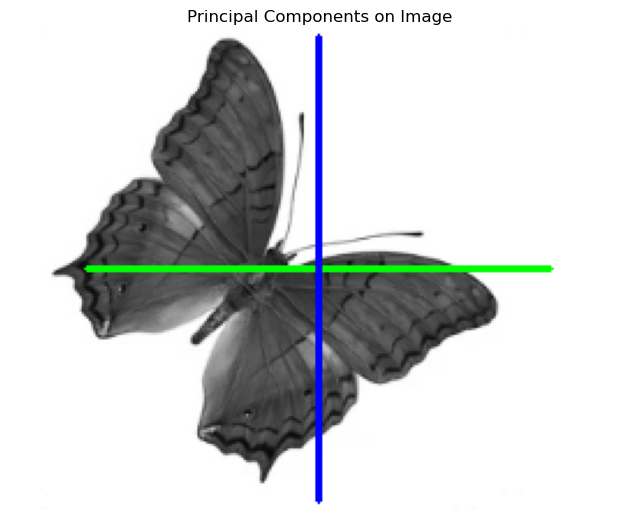

Explained Variance Ratios: [0.56122216 0.43877784]


In [32]:
# Example usage
image_path3 = r"C:\Users\suyash\OneDrive - iiit-b\Projects\Adobe_GenSolve\butterfly2.png"
image3 = load_and_convert_to_grayscale(image_path3)

# cv2.rectangle(image, (150, 150), (350, 350), 255, -1)  # Drawing a white rectangle for testing

# Draw principal components
result_image3, pca3 = draw_principal_components(image3, n_components=2)

# Plot the result
plt.figure(figsize=(8, 8))
plt.imshow(result_image3, cmap='gray')
plt.title('Principal Components on Image')
plt.axis('off')
plt.show()

print(f"Explained Variance Ratios: {pca.explained_variance_ratio_}")

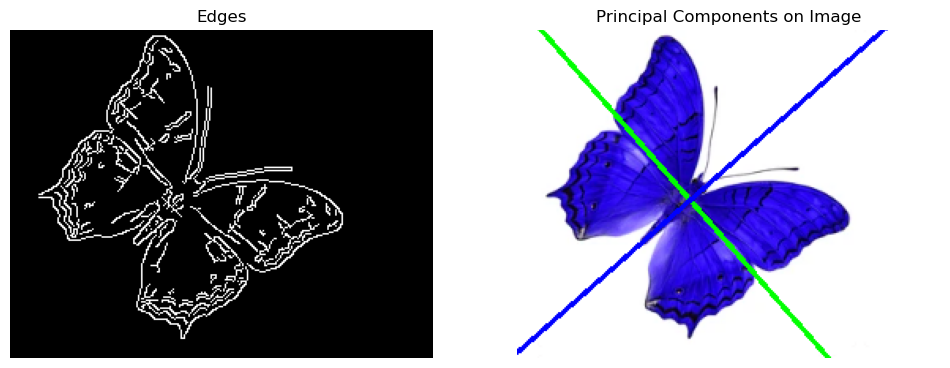

Explained Variance Ratios: [0.6477051 0.3522949]


In [37]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def extract_polylines(image):
    # Convert image to grayscale if it's not already
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image.copy()
    
    # Apply Canny edge detection
    edges = cv2.Canny(gray_image, 100, 200)
    
    # Find contours in the edges
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Convert contours to polylines
    polylines = [contour.reshape(-1, 2) for contour in contours]
    
    return polylines, edges

def draw_principal_components2(image, polylines, n_components=2):
    # Combine all polylines into a single array of points
    points = np.vstack([polyline for polyline in polylines])
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca.fit(points)

    # Get the principal components and the mean
    components = pca.components_
    mean_point = pca.mean_

    # Convert to color image to draw colored lines
    if len(image.shape) == 2:
        color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        color_image = image.copy()

    # Draw the principal components
    for i, component in enumerate(components):
        # Extend the line in both directions
        start_point = (mean_point - component * 200).astype(int)
        end_point = (mean_point + component * 200).astype(int)
        
        # Define colors for each principal component
        color = (0, 255, 0) if i == 0 else (0, 0, 255) if i == 1 else (255, 0, 0)  # Green, Red, Blue
        
        # Draw the line
        cv2.line(color_image, tuple(start_point[::-1]), tuple(end_point[::-1]), color, 2)

    return color_image, pca

# Example usage
image_path = r"C:\Users\suyash\OneDrive - iiit-b\Projects\Adobe_GenSolve\butterfly2.png"
image = cv2.imread(image_path)

# Extract polylines from the image
polylines, edges = extract_polylines(image)

# Draw principal components
result_image, pca = draw_principal_components2(image, polylines, n_components=2)

# Plot the result
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.title('Edges')
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Principal Components on Image')
plt.imshow(result_image)
plt.axis('off')
plt.show()

print(f"Explained Variance Ratios: {pca.explained_variance_ratio_}")